
# Híbrido Prophet + (ARIMA/Kalman) em resíduos — pipeline pronto

Este notebook:
1) carrega sua série (`ds`, `y`, opcional `wavestream`),  
2) **(opcional)** decima ou reamostra (sem "média" se quiser),  
3) ajusta **Prophet** na componente lenta,  
4) calcula **resíduos** e modela com **ARIMA** ou **Kalman**,  
5) combina as previsões `ŷ = ŷ_prophet + ŷ_resid`,  
6) calcula métricas **band-limited** e **probabilísticas** adequadas a séries HF.

> **Como usar:** no bloco 1, aponte `DF_SOURCE` (um DataFrame já no kernel ou um CSV) e escolha `CONFIG`. Depois execute tudo.


In [1]:

# Bloco 1 — Imports e configurações
import numpy as np
import pandas as pd
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Tuple

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

import statsmodels.api as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents

import matplotlib.pyplot as plt


In [2]:

@dataclass
class Config:
    # Entrada / preparo
    datetime_col: str = 'ds'
    value_col: str = 'y'
    reg_cols: tuple = tuple()        # e.g., ('wavestream',)
    # Decimação (sem média) OU reamostragem (com agregação)
    decimate_k: Optional[int] = None # e.g., 6 => pega 1 de cada 6 amostras
    resample_rule: Optional[str] = None # ex.: '1S' ou '1min'; se None, mantém original
    resample_agg: str = 'median'     # 'median' ou 'mean'
    # Prophet
    daily: bool = True
    weekly: bool = True
    seasonality_mode: str = 'additive'
    changepoint_prior_scale: float = 0.05
    seasonality_prior_scale: float = 1.0
    extra_seasonalities: Tuple[Tuple[str,float,int],...] = tuple()  # (name, period_days, fourier)
    growth: str = 'linear'           # ou 'logistic' + cap/floor nas colunas
    # Horizonte e frequência de previsão
    horizon: str = '60min'
    freq: Optional[str] = None       # ex.: '1S' (usa a do índice se None)
    # Métricas (passa-baixa para avaliação)
    lf_window: int = 31              # janelas por amostra (se índice é regular)
    # Split temporal (holdout)
    test_frac: float = 0.2
    # Residual model
    residual_model: str = 'arima'    # 'arima' ou 'kalman'

CFG = Config()
print(CFG)

Config(datetime_col='ds', value_col='y', reg_cols=(), decimate_k=None, resample_rule=None, resample_agg='median', daily=True, weekly=True, seasonality_mode='additive', changepoint_prior_scale=0.05, seasonality_prior_scale=1.0, extra_seasonalities=(), growth='linear', horizon='60min', freq=None, lf_window=31, test_frac=0.2, residual_model='arima')


In [3]:

# Bloco 2 — Carregar dados
# Opção A: já tem um DataFrame 'df' no kernel (com colunas ds,y)?
#          Então apenas assegure datetime e ordenação:
try:
    assert 'df' in globals()
    df = df.copy()
    print("Usando DataFrame 'df' já presente no kernel.")
except AssertionError:
    # Opção B: leia de CSV (ajuste o caminho abaixo)
    CSV_PATH = ''  # ex.: '/path/dados.csv'
    if CSV_PATH:
        df = pd.read_csv(CSV_PATH)
        print(f"Carregado de {CSV_PATH}")
    else:
        # Gerar um exemplo sintético se nada fornecido
        print("Nenhum df no kernel nem CSV informado — gerando série sintética para exemplo.")
        idx = pd.date_range('2025-07-14', periods=8000, freq='160ms')
        rng = np.random.default_rng(42)
        slow = 0.2*np.sin(2*np.pi*(1/60)*np.arange(len(idx)))   # ~1min pseudo-sazonal
        y = slow + 0.25*rng.standard_normal(len(idx))
        df = pd.DataFrame({'ds': idx, 'y': y})

# Assegurar datetime e sort
df[CFG.datetime_col] = pd.to_datetime(df[CFG.datetime_col])
df = df.dropna(subset=[CFG.datetime_col, CFG.value_col]).sort_values(CFG.datetime_col).reset_index(drop=True)
df.head()

Nenhum df no kernel nem CSV informado — gerando série sintética para exemplo.


,ds,y
0,2025-07-14 00:00:00.000,0.076179
1,2025-07-14 00:00:00.160,-0.239090
2,2025-07-14 00:00:00.320,0.229195
3,2025-07-14 00:00:00.480,0.296945
4,2025-07-14 00:00:00.640,-0.406411


In [4]:

# Bloco 3 — Decimação ou reamostragem (escolha pelo Config)
def prepare_timeseries(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    out = df.copy()
    out = out[[cfg.datetime_col, cfg.value_col] + list(cfg.reg_cols)].copy()
    out[cfg.datetime_col] = pd.to_datetime(out[cfg.datetime_col])
    if cfg.decimate_k and cfg.decimate_k > 1:
        out = out.iloc[::cfg.decimate_k].reset_index(drop=True)
    if cfg.resample_rule:
        out = (out.set_index(cfg.datetime_col)
                 .resample(cfg.resample_rule)
                 .agg({cfg.value_col: cfg.resample_agg, **{c:'median' for c in cfg.reg_cols}})
                 .dropna()
                 .reset_index())
    return out

dfp = prepare_timeseries(df, CFG)
dfp.info()
dfp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      8000 non-null   datetime64[ns]
 1   y       8000 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 125.1 KB


,ds,y
0,2025-07-14 00:00:00.000,0.076179
1,2025-07-14 00:00:00.160,-0.239090
2,2025-07-14 00:00:00.320,0.229195
3,2025-07-14 00:00:00.480,0.296945
4,2025-07-14 00:00:00.640,-0.406411


In [5]:

# Bloco 4 — Split temporal (treino/teste)
def temporal_split(dfp: pd.DataFrame, cfg: Config):
    n = len(dfp)
    n_tr = int((1 - cfg.test_frac) * n)
    train = dfp.iloc[:n_tr].copy()
    test  = dfp.iloc[n_tr:].copy()    
    return train, test

train, test = temporal_split(dfp, CFG)
len(train), len(test), train.head(2), test.head(2)

(6400,
 1600,
                        ds         y
 0 2025-07-14 00:00:00.000  0.076179
 1 2025-07-14 00:00:00.160 -0.239090,
                           ds         y
 6400 2025-07-14 00:17:04.000  0.097728
 6401 2025-07-14 00:17:04.160 -0.422057)

In [6]:
conf2 = {
    "SEED": 42,
    "fft" : {
        "enabled": True,
        "plot_fft": False,
        "convert_period": {
            "hour2day": False,
            "month2day": False
        },
        "sel_freqs": { 
            "enabled": True,           
            "method": "N-Head",
            "clustering": {
                            "K": 800
            },
            "N-Head": {
                "n": 400,
            },
            "N-Tail": {
                "n": 300,
            },
            "binning": {
                "n": 200,
            },
        },      
    },
    "prophet":{
        "weekly_seasonality": False,
        "daily_seasonality": False,
        "yearly_seasonality": False,
        "interval_width": 0.80,
        "mcmc_samples": 0,
        "uncertainty_samples": 1000,        
        "changepoint_prior_scale": 0.05,        
        "changepoint_range": 0.8,
        "n_changepoints": 25,
        "extra_regressors": {
            "enabled" : False,
            "names": ['TSA', 'PDO']
        },
        "fourier_order": 1,
        "mode": "additive",
        "synthetic_time": True, #For seasonality less than 1 day
    }, 
    "verbose": 1
}

In [7]:
train

,ds,y
0,2025-07-14 00:00:00.000,0.076179
1,2025-07-14 00:00:00.160,-0.239090
2,2025-07-14 00:00:00.320,0.229195
3,2025-07-14 00:00:00.480,0.296945
4,2025-07-14 00:00:00.640,-0.406411
...,...,...
6395,2025-07-14 00:17:03.200,-0.163307
6396,2025-07-14 00:17:03.360,0.174444
6397,2025-07-14 00:17:03.520,-0.450598
6398,2025-07-14 00:17:03.680,-0.405631


[I] Encontrando as sazonalidades
[I] FFT
[I] Máx freqs: 1068
[I] N-Head 400
[I] Criando Modelo


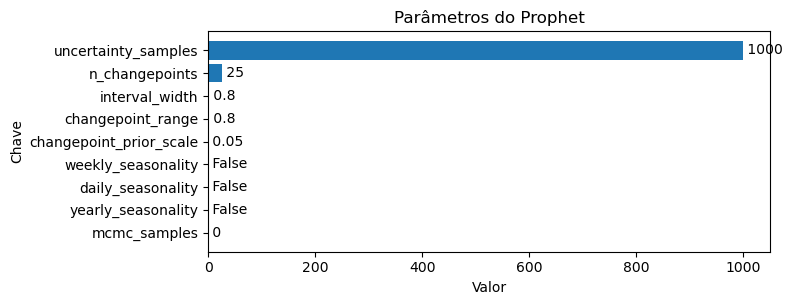

[I] Adicionando Sazonalidades
[I] Ajustando o modelo


14:55:51 - cmdstanpy - INFO - Chain [1] start processing
14:55:58 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,T10.158730158730158,T10.158730158730158_lower,T10.158730158730158_upper,T10.19108280254777,...,T98.46153846153845,T98.46153846153845_lower,T98.46153846153845_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-07-14 00:00:00.000,0.075978,-0.380760,0.367877,0.075978,0.075978,-0.000195,-0.000195,-0.000195,-0.000195,...,-0.000193,-0.000193,-0.000193,-0.08378,-0.08378,-0.08378,0.0,0.0,0.0,-0.007802
1,2025-07-14 00:00:00.160,0.075977,-0.368594,0.352800,0.075977,0.075977,-0.000195,-0.000195,-0.000195,-0.000195,...,-0.000193,-0.000193,-0.000193,-0.08378,-0.08378,-0.08378,0.0,0.0,0.0,-0.007803
2,2025-07-14 00:00:00.320,0.075976,-0.372032,0.373527,0.075976,0.075976,-0.000195,-0.000195,-0.000195,-0.000195,...,-0.000193,-0.000193,-0.000193,-0.08378,-0.08378,-0.08378,0.0,0.0,0.0,-0.007804
3,2025-07-14 00:00:00.480,0.075975,-0.370795,0.355395,0.075975,0.075975,-0.000195,-0.000195,-0.000195,-0.000195,...,-0.000193,-0.000193,-0.000193,-0.08378,-0.08378,-0.08378,0.0,0.0,0.0,-0.007805
4,2025-07-14 00:00:00.640,0.075973,-0.393233,0.352631,0.075973,0.075973,-0.000195,-0.000195,-0.000195,-0.000195,...,-0.000193,-0.000193,-0.000193,-0.08378,-0.08378,-0.08378,0.0,0.0,0.0,-0.007806


In [8]:
from src.atm_timeseries.profeta import Profeta

prf = Profeta(conf2)
m = prf.fit(train)
future = dfp[['ds']]
fcst = m.predict(future)
fcst.head()

# # Bloco 5 — Prophet (com regressoras e sazonalidades opcionais)
# def fit_prophet(train, cfg):
#     cols = [cfg.datetime_col, cfg.value_col] + list(cfg.reg_cols)

#     # >>> torne 'ds' ingênuo (sem tz) antes de passar ao Prophet
#     df_fit = train[cols].rename(columns={cfg.datetime_col: 'ds',
#                                          cfg.value_col: 'y'}).copy()
#     df_fit['ds'] = pd.to_datetime(df_fit['ds'], utc=True, errors='coerce') \
#                        .dt.tz_convert(None)   # remove o UTC

#     m = Prophet(daily_seasonality=cfg.daily, weekly_seasonality=cfg.weekly,
#                 seasonality_mode=cfg.seasonality_mode,
#                 changepoint_prior_scale=cfg.changepoint_prior_scale,
#                 seasonality_prior_scale=cfg.seasonality_prior_scale,
#                 growth=cfg.growth)
#     for c in cfg.reg_cols:
#         m.add_regressor(c, standardize=True)

#     m.fit(df_fit)
#     return m

# m = fit_prophet(train, CFG)

# # Previsões no histórico + futuro (horizonte)
# freq = CFG.freq or pd.infer_freq(pd.to_datetime(dfp[CFG.datetime_col]))
# H = CFG.horizon
# #future = m.make_future_dataframe(periods=pd.Timedelta(H).components.days*int(24*60*60/(pd.to_timedelta(freq).total_seconds())) if freq else 0,
# #                                 freq=freq)
# future = dfp[['ds']]

# for c in CFG.reg_cols:
#     if c in dfp.columns:
#         # hold-last simples para o futuro (ajuste se tiver previsor próprio)
#         value = train[c].iloc[-1]
#         future[c] = value
# fcst = m.predict(future)
# fcst.head()

In [9]:
fcst.shape

(8000, 1213)

In [10]:

# Bloco 6 — Resíduos in-sample alinhados
hist = train.merge(fcst[['ds','yhat']], on='ds', how='left').dropna()
resid = (hist['y'] - hist['yhat']).rename('resid')
resid.index = hist['ds']
resid.head()

ds
2025-07-14 00:00:00.000    0.083981
2025-07-14 00:00:00.160   -0.231287
2025-07-14 00:00:00.320    0.236999
2025-07-14 00:00:00.480    0.304750
2025-07-14 00:00:00.640   -0.398605
Name: resid, dtype: float64

In [11]:
resid.shape

(6400,)

In [12]:

# Bloco 7 — Modelagem do resíduo (ARIMA ou Kalman)
def forecast_residuals(resid: pd.Series, cfg: Config, steps: int) -> Tuple[np.ndarray, np.ndarray]:
    if cfg.residual_model.lower() == 'kalman':
        mod = UnobservedComponents(resid, level='local level')
        res = mod.fit(disp=False)
        f = res.get_forecast(steps=steps)
        mean = f.predicted_mean.to_numpy()
        se = np.sqrt(np.diag(f.covariance_matrix))
        return mean, se
    else:
        # ARIMA básico e parcimonioso (2,0,2). Ajuste conforme ACF/PACF dos resíduos.
        arima = sm.tsa.SARIMAX(resid, order=(2,0,2), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        f = arima.get_forecast(steps=steps)
        return f.predicted_mean.to_numpy(), f.se_mean.to_numpy()

# nº de passos no teste
steps = len(test)
res_mean, res_se = forecast_residuals(resid, CFG, steps)
len(res_mean), len(res_se)

(1600, 1600)

In [13]:

# Bloco 8 — Combinar previsões
# Prophet no futuro (parte teste)
fc_test = fcst.set_index('ds').loc[test['ds']]
yhat_prophet = fc_test['yhat'].to_numpy()

yhat_final = yhat_prophet + res_mean

# Intervalos (aprox. independência): combine variâncias
from scipy.stats import norm
z = norm.ppf(0.9)  # 80% PI
sigma_prophet = ((fc_test['yhat_upper'] - fc_test['yhat_lower'])/(2*z)).to_numpy()
sigma_total = np.sqrt(sigma_prophet**2 + res_se**2)
yhat_lo = yhat_final - z*sigma_total
yhat_hi = yhat_final + z*sigma_total

pred = pd.DataFrame({
    'ds': test['ds'].values,
    'y':  test['y'].values,
    'yhat_prophet': yhat_prophet,
    'yhat_final': yhat_final,
    'yhat_lo': yhat_lo,
    'yhat_hi': yhat_hi
})
pred.head()

,ds,y,yhat_prophet,yhat_final,yhat_lo,yhat_hi
0,2025-07-14 00:17:04.000,0.097728,0.009833,-0.163622,-0.669780,0.342535
1,2025-07-14 00:17:04.160,-0.422057,0.009836,-0.173947,-0.683413,0.335519
2,2025-07-14 00:17:04.320,-0.184192,0.009838,-0.182257,-0.688424,0.323909
3,2025-07-14 00:17:04.480,-0.541024,0.009840,-0.188462,-0.696281,0.319357
4,2025-07-14 00:17:04.640,-0.244209,0.009843,-0.192493,-0.704504,0.319518


In [14]:

# Bloco 9 — Métricas (band-limited, correlação/lag, probabilísticas)
def rmse(a,b): return float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))
def mae(a,b):  return float(np.mean(np.abs(np.asarray(a)-np.asarray(b))))

def sma(s, w):
    s = pd.Series(s).reset_index(drop=True)
    return s.rolling(w, min_periods=1, center=True).mean()

def best_lag(y, yhat, maxlag=50):
    y = pd.Series(y).reset_index(drop=True)
    yhat = pd.Series(yhat).reset_index(drop=True)
    lags = range(-maxlag, maxlag+1)
    cors = [y.corr(yhat.shift(k)) for k in lags]
    k = int(np.nanargmax(cors))
    return lags[k], float(cors[k])

def coverage(y, lo, hi):
    y, lo, hi = map(np.asarray, (y,lo,hi))
    return float(np.mean((y>=lo) & (y<=hi)))

def winkler(y, lo, hi, alpha=0.2):
    y, lo, hi = map(np.asarray, (y,lo,hi))
    W = (hi-lo)/2.0
    pen = 2/alpha
    WL = (hi - lo).astype(float)
    maskL = y < lo; maskH = y > hi
    WL[maskL] += pen*(lo[maskL] - y[maskL])
    WL[maskH] += pen*(y[maskH] - hi[maskH])
    return float(np.mean(WL))

# Série teste
y_true = pred['y']; yhat = pred['yhat_final']

# Band-limited (LF window)
w = CFG.lf_window
y_lf, yhat_lf = sma(y_true, w), sma(yhat, w)
RMSE_LF = rmse(y_lf, yhat_lf)
RMSE_HF = rmse(y_true - y_lf, yhat - yhat_lf)

r0 = pd.Series(y_true).corr(pd.Series(yhat))
lag_opt, r_opt = best_lag(y_true, yhat, maxlag=50)

# Skill vs persistência (no domínio teste)
naive = pred['y'].shift(1).dropna()
SS = 1 - rmse(pred['y'][1:], yhat[1:]) / rmse(pred['y'][1:], naive)

COV = coverage(pred['y'], pred['yhat_lo'], pred['yhat_hi'])
WINK = winkler(pred['y'], pred['yhat_lo'], pred['yhat_hi'], alpha=0.2)

print(f"RMSE_LF={RMSE_LF:.4f} | RMSE_HF={RMSE_HF:.4f} | r0={r0:.3f} | lag_opt={lag_opt} | r_opt={r_opt:.3f} | SS={SS:.3f}")
print(f"Coverage80={COV:.3f} | Winkler80={WINK:.4f}")

RMSE_LF=0.0497 | RMSE_HF=0.2436 | r0=0.513 | lag_opt=0 | r_opt=0.513 | SS=0.300
Coverage80=0.962 | Winkler80=1.0613


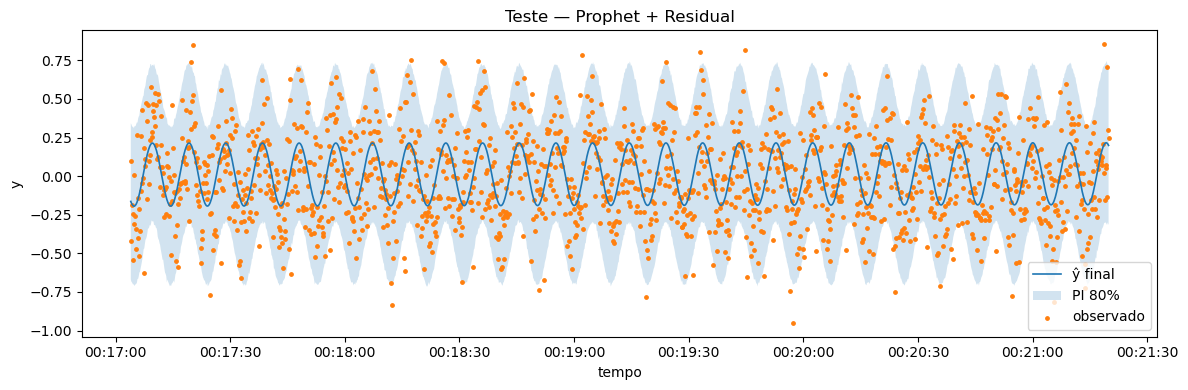

In [15]:

# Bloco 10 — Gráfico final (teste): y, yhat_final e PI 80%
plt.figure(figsize=(12,4))
plt.plot(pred['ds'], pred['yhat_final'], label='ŷ final', linewidth=1.2)
plt.fill_between(pred['ds'], pred['yhat_lo'], pred['yhat_hi'], alpha=0.2, label='PI 80%')
plt.scatter(pred['ds'], pred['y'], s=6, label='observado')
plt.legend(); plt.title('Teste — Prophet + Residual'); plt.xlabel('tempo'); plt.ylabel('y')
plt.tight_layout(); plt.show()